## **Numerical modeling of drainage evolution**

This tutorial provides a numerical modeling case of drainage evolution influenced by tectonics coupled with surface processes. It's a 3-D fully coupled model built by UWGeodyanmics module [(Beucher et al., 2018)](https://www.theoj.org/joss-papers/joss.01136/10.21105.joss.01136.pdf). This model is mostly based on the 3-D thermo-mechanical tectonic model from [(Chen et al., 2017)](https://www.nature.com/articles/ncomms15992), which evaluates the effects of crustal rheology on the formation of the Himalayan-Tibetan orogenic system. This model has similar geometry and rheology but different boundary conditions with their Model-3, and beening coupled with surface processes.


### **Model settings**

Cartesian domain: 1000×1000×(200+40) km (x, y, z)

Eulerian nodes (recomended): 128×128×32 


**Boundary conditions**

Free slip boundary condition is used at the back (y = 1000 km) and left (x = 0 km). 
A depth-constant horizontal velocity is imposed at the front wall (y = 0 km), which simulates the northward moving of the Indian lithosphere. The sticky air method is used at the top to simulate a free surface. The airy isostatic model is applied at the bottom. 

The thermal boundary conditions are the absolute temperatures as 0 °C in the air and 1360 °C in the mantle asthenosphere, and the heat flux at the bottom.


**Rheology**

The strength of the crust and mantle are represented by the non-newtonian rheology as the combination of the viscous and plastic rheology ( η = min { ηviscous, ηplastic }). The viscous rheology is implemented through viscous diffusion and dislocation creep. The plastic rheology is defined using a Drucker-Prager yield-criterion.


**Differences from Model-3**

Model-3 in (Chen et al., 2017) has the infinity-like constant external temperature condition and the infinity-like external free slip condition at the model bottom. Their model considers the initial height of the Asian surface. And their model has a more complex thermal structure including the influence of the partially molten processes.


### **Numerical implementation**

The UWGeodynamics module [(Beucher et al., 2018)](https://www.theoj.org/joss-papers/joss.01136/10.21105.joss.01136.pdf) is used here to develop numerical models. This module is based on Underworld 2 (Moresi et al., 2007) and combines it with Badlands (Salles et al., 2018). The model derived by UWGeodynamics is a two-way coupled thermo-mechanical model with surface processes, where the velocity field retrieved from the thermo-mechanical model is used to advect the surface in the surface processes model. The surface subjected to erosion and deposition. The distribution of materials in the model is then updated.

Docker is highly recommended to run the module. The recommended image version of UWGeodynamics is: underworldcode/uwgeodynamics: 2.8.4 (or above).

### **Visualisation**

For an in-depth visualisation of the model output, it is recommended to use a visualisation package such as [Paraview](http://www.paraview.org).

**Underworld** outputs are created in the directory you've specified in this script. The folder contains xdmf series files: **XDMF.fields.xdmf** which will display the time series of all fields (e.g. temperature, velocity, rheology et al.).

**Badlands** outputs are created in the directory you've specified in your **XmL** input file. The folder contains xdmf series files:
+ **tin.series.xdmf** which will display the time series of surface evolution.
+ **flow.series.xdmf** which will display the time series of drainage network evolution.


In [13]:
import UWGeodynamics as GEO
import glucifer
import numpy as np
import underworld.function as fn

### Model Scaling

In [2]:
#Res_mesh = (128,128,32)
Res_mesh = (8,8,16)
Res_real = (1000.,1000.,240.) # Unit: km 

# Scaling
u = GEO.UnitRegistry
velocity = 3.3 * u.centimetre / u.year
half_rate = velocity
model_length  = Res_real[1] * u.kilometer
surfaceTemp   = 273.15 * u.degK # 0 * u.degC
baseModelTemp = 1633.15 * u.degK # 1360 * u.degC
bodyforce = (3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2) 

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Model mesh
Model = GEO.Model(elementRes=Res_mesh,
                  minCoord=(0. * u.kilometer, 0. * u.kilometer, -200. * u.kilometer),  
                  maxCoord=(Res_real[0] * u.kilometer, Res_real[1] * u.kilometer, 40. * u.kilometer), 
                  gravity=(0.0, 0.0, -9.81 * u.meter / u.second**2))

Model.outputDir="Output_CM"

### Material Setup

In [3]:
# shape of the materials

air_Shape = GEO.shapes.Layer3D(top=Model.top, bottom=0. * u.kilometer)

x_inden     = 800. * u.kilometer     # [km] initial coord in x of the indenter
x_transzone = 100. * u.kilometer     # [km] initial coord in x of the indenter
x_trans     = 800. * u.kilometer     # [km] initial coord in x of the transform zone
x_trans_mid = 750. * u.kilometer     # [km] initial coord in x of the mid-point of the transform zone 
y_inden     = 100. * u.kilometer     # [km] initial coord in y of the indenter
y_trans     = 150. * u.kilometer     # [km] initial coord in y of the transform zone
y_trans_mid = 125. * u.kilometer     # [km] initial coord in y of the mid-point of the transform zone 
x_half      = Model.maxCoord[0]/2.   # [km] 
y_half      = Model.maxCoord[1]/2.   # [km] 

# AUC and ALC
auc_Shape = GEO.shapes.Layer3D(top= 0. * u.kilometer, bottom=-17. * u.kilometer)
alc_Shape = GEO.shapes.Layer3D(top= -17. * u.kilometer, bottom=-40. * u.kilometer)

# MA
layer1 = GEO.shapes.Layer3D(top=-140. * u.kilometer, bottom=Model.bottom)
layer2 = GEO.shapes.Layer3D(top=-120. * u.kilometer, bottom=-140. * u.kilometer)
hs1    = GEO.shapes.HalfSpace(normal=(0.,-2.,5.),origin=(x_half, y_trans_mid, -130. * u.kilometer))
hs_1   = GEO.shapes.HalfSpace(normal=(0.,2.,-5.),origin=(x_half, y_trans_mid, -130. * u.kilometer))
hs2    = GEO.shapes.HalfSpace(normal=(-2.,0.,5.),origin=(x_trans_mid, y_half, -130. * u.kilometer))
hs_2   = GEO.shapes.HalfSpace(normal=(2.,0.,-5.),origin=(x_trans_mid, y_half, -130. * u.kilometer))

ma_Shape = layer1 | (layer2 & hs1) | (layer2 & hs_1 & hs2)

# ML
layer3 = GEO.shapes.Layer3D(top=-40. * u.kilometer, bottom=-120. * u.kilometer)
layer4 = GEO.shapes.Layer3D(top=-35. * u.kilometer, bottom=-40. * u.kilometer)
hs3    = GEO.shapes.HalfSpace(normal=(0.,1.,10.),origin=(x_half, y_trans_mid, -37.5 * u.kilometer))
hs4    = GEO.shapes.HalfSpace(normal=(1.,0.,10.),origin=(x_trans_mid, y_half, -37.5 * u.kilometer))

ml_Shape = layer3 | (layer2 & hs_1 & hs_2) | (layer4 & hs3 & hs4)

# IUC and ILC
iuc_Shape = GEO.shapes.Box(minX=Model.minCoord[0],maxX=x_inden,
                            minY=Model.minCoord[1],maxY=y_trans,
                            top= 0. * u.kilometer, bottom=-15. * u.kilometer)

ilc_Shape1 = GEO.shapes.Box(minX=Model.minCoord[0],maxX=x_inden,
                            minY=Model.minCoord[1],maxY=y_trans,
                            top= -15. * u.kilometer, bottom=-35. * u.kilometer)

hs_3  = GEO.shapes.HalfSpace(normal=(0.,-1.,-10.),origin=(x_half, y_trans_mid, -37.5 * u.kilometer))
hs_4  = GEO.shapes.HalfSpace(normal=(-1.,0.,-10.),origin=(x_trans_mid, y_half, -37.5 * u.kilometer))
hs5   = GEO.shapes.HalfSpace(normal=(0.,1.,0.),origin=(x_half, y_trans, -37.5 * u.kilometer))
hs6   = GEO.shapes.HalfSpace(normal=(0.,0.,1.),origin=(x_half, y_half, -35. * u.kilometer))
hs7   = GEO.shapes.HalfSpace(normal=(1.,0.,0.),origin=(x_trans, y_half, -37.5 * u.kilometer))

ilc_Shape = ilc_Shape1 | (hs6 & hs7 & hs_3 & hs5) | (hs6 & hs7 & hs_4 & hs3)

# BlC
x_block = 200. * u.kilometer 
y_block = y_trans
blc_Shape =  GEO.shapes.Box(minX=Model.minCoord[0],maxX=x_block,
                            minY=y_block,maxY=Model.maxCoord[1],
                            top= -17. * u.kilometer, bottom=-40. * u.kilometer)

In [4]:
air = Model.add_material(name="Air", shape=air_Shape)

auc = Model.add_material(name="Asian Upper Crust", shape=auc_Shape)
alc = Model.add_material(name="Asian Lower Crust", shape=alc_Shape)

ma  = Model.add_material(name="Mantle Asthenosphere", shape=ma_Shape)
ml  = Model.add_material(name="Mantle Lithosphere", shape=ml_Shape)

iuc = Model.add_material(name="Indenter Upper Crust", shape=iuc_Shape)
ilc = Model.add_material(name="Indenter Lower Crust", shape=ilc_Shape)

sediment = Model.add_material(name="Sediment")
blc = Model.add_material(name="Block", shape=blc_Shape)

### Tracers

In [5]:
# # add tracer
x_nodes = 250
y_nodes = 250
x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), x_nodes)
y = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), y_nodes)
x,y = np.meshgrid(x,y)
z1 = GEO.nd(0.* u.kilometer)

z2 = np.ones(x_nodes*y_nodes)*GEO.nd(-40.* u.kilometer)
for index, items in enumerate(x.ravel()):
    if x.ravel()[index] < GEO.nd(x_inden):
        if y.ravel()[index] < GEO.nd(y_inden):
             z2[index] = GEO.nd(-35.* u.kilometer)
        elif y.ravel()[index] < GEO.nd(y_trans):
             z2[index] = GEO.nd(-40.* u.kilometer) + (GEO.nd(y_trans)-y.ravel()[index])/50.*5.
        
surf_tracers = Model.add_passive_tracers(name="Surface", vertices=[x.ravel(),y.ravel(),z1], zOnly=True)
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[x.ravel(),y.ravel(),z2], zOnly=True)
# surface_tracers.add_tracked_field()


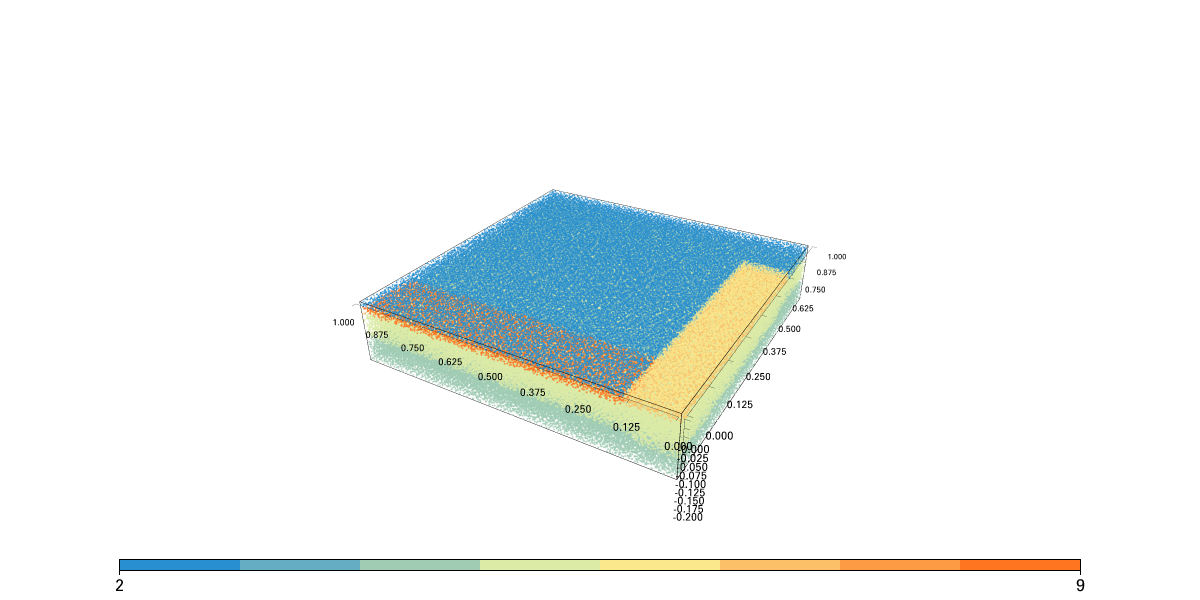

In [6]:
Fig = glucifer.Figure(resolution=(1200,600))
#Fig = glucifer.Figure(resolution=(1200,600),rulers=True,
#                      margin=0.1,rulerticks=9,rulerwidth=0.5,fontscale=1.5)
#Fig.IsoSurface(Model.mesh, Model.projMaterialField, discrete=True,isovalues=[0.5], isowalls=True, shift=1)
Fig.Points(Model.swarm, Model.materialField, discrete=True,fn_mask= Model.materialField > air.index,fn_size = 3.)
#Fig.Points(surf_tracers, colour= 'black',pointSize=2.0)
#Fig.Points(moho_tracers, colour= 'black', pointSize=2.0)

camera = ['rotate z 60', 'rotate x -60','zoom 0.1']
Fig.script(camera)
Fig.show()

# viewer = Fig.viewer(resolution=(1200,600))
# viewer.rotatex(-60)
# viewer.window()

### Model properties

In [7]:
# density
air.density = 1 * u.kilogram / u.metre**3

r_tE = 3e-5 / u.kelvin
r_tem = 298 * u.kelvin
r_beta = 10 / u.pascal
r_pre = 0.1e6 * u.pascal

ma.density  = GEO.LinearDensity(3300. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem)                                                     
ml.density  = GEO.LinearDensity(3300. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem)   

auc.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem) 
iuc.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem)  

alc.density = GEO.LinearDensity(2800. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem)   
ilc.density = GEO.LinearDensity(2800. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem)   

sediment.density = GEO.LinearDensity(2700. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem) 

blc.density = GEO.LinearDensity(2800. * u.kilogram / u.metre**3,thermalExpansivity = r_tE,
                                reference_temperature = r_tem) 

#### Rheology

Under lower-pressure and high-stress conditions, plastic deformation of materials follows the Drucker-Prager yield criterion \citep{Ranalli1995}:

$\eta_{plastic}= \frac{\sigma_{yield}}{2\dot{\epsilon}}$

$\sigma_{yield}=C_{0}+\sin(\varphi)P$

where $\dot{\epsilon}=(\frac{1}{2}\dot{\epsilon}_{ij}\dot{\epsilon}_{ij})^{1/2}$ is the second invariant of the strain rate tensor; $C_{0}$ is the residual strength of rocks at $P=0$; $\varphi$ represents the internal angle of friction under the dry condition.

As pressure increases, the deformation mechanism of rock changes from plastic to viscous (ductile). In contrast to plastic deformation, viscous deformation strongly depends on rock type, temperature, pressure, and strain rate \citep{Ranalli1995}:

$\eta_{viscous}=\frac{1}{2}fA_{D}^{-\frac{1}{n}}\dot{\epsilon}^{\frac{1-n}{n}}\exp\left ( \frac{E_{a}+PV_{a}}{nRT} \right )$

where $A_{D}$ is the prefactor. $R$, $n$, $E_{a}$, and $V_{a}$ denote the universal gas constant, stress exponent, activation energy and activation volume, repectively.

$\eta _{0}=(1/A_{D})*10^{(6n)}$

$\eta _{eff}= min(\eta _{plastic}, \eta _{viscous})$

In [8]:
# Viscosity
rh=GEO.ViscousCreepRegistry()

Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e24 * u.pascal * u.second

air.viscosity      = 1e18 * u.pascal * u.second

ml.viscosity  = GEO.ViscousCreep(name='Dry Olivine (Chen2017)',
                                 preExponentialFactor=2.5e4/u.megapascal ** 3.5 /u.second,
                                 stressExponent=3.5,
                                 activationVolume=8e-6*u.meter ** 3 / u.mole,activationEnergy=532 * u.kilojoules/u.mole,
                                 f=1.0)  # Dry Olivine (Ranalli, 1995) eta _{0}=3.98e16

ma.viscosity  = GEO.ViscousCreep(name='Dry Olivine (Chen2017)',
                                 preExponentialFactor=2.5e4/u.megapascal ** 3.5 /u.second,
                                 stressExponent=3.5,
                                 activationVolume=8e-6*u.meter ** 3 / u.mole,activationEnergy=532 * u.kilojoules/u.mole,
                                 f=1.0)  # Dry Olivine (Ranalli, 1995) eta _{0}=3.98e16

auc.viscosity = GEO.ViscousCreep(name='Wet Quartzite (Chen2017)',
                                 preExponentialFactor=3.2e-4/u.megapascal ** 2.3 /u.second,
                                 stressExponent=2.3,
                                 activationVolume=0.,activationEnergy=154 * u.kilojoules/u.mole,
                                 f=1.0)  # Wet Quartzite (Ranalli, 1995) eta _{0}=1.97e17
iuc.viscosity = GEO.ViscousCreep(name='Wet Quartzite (Chen2017)',
                                 preExponentialFactor=3.2e-4/u.megapascal ** 2.3 /u.second,
                                 stressExponent=2.3,
                                 activationVolume=0.,activationEnergy=154 * u.kilojoules/u.mole,
                                 f=1.0)  # Wet Quartzite (Ranalli, 1995) eta _{0}=1.97e17

alc.viscosity = GEO.ViscousCreep(name='Mafic Granulite (Chen2017)',
                                 preExponentialFactor=0.01/u.megapascal ** 3.2 /u.second,
                                 stressExponent=3.2,
                                 activationVolume=0.,activationEnergy=244 * u.kilojoules/u.mole
                                 ,f=1.0)  # Mafic Granulite    (Wang et al., 2012) eta _{0}=1.58e21

ilc.viscosity = GEO.ViscousCreep(name='Plagioclase An75 (Chen2017)',
                                 preExponentialFactor=3.3e-4/u.megapascal ** 3.2 /u.second,
                                 stressExponent=3.2,
                                 activationVolume=0.,activationEnergy=238 * u.kilojoules/u.mole,
                                 f=1.0)  # Plagioclase An75 (Ranalli, 1995) eta _{0}=4.8e22

blc.viscosity = GEO.ViscousCreep(name='Maryland Diabase (Chen2017)',
                                 preExponentialFactor=8./u.megapascal ** 4.7 /u.second,
                                 stressExponent=4.7,
                                 activationVolume=0.,activationEnergy=485 * u.kilojoules/u.mole
                                 ,f=1.0)  # Maryland Diabase   (Ranalli, 1995) eta _{0}=1.98e27

sediment.viscosity = GEO.ViscousCreep(name='Wet Quartzite (Chen2017)',
                                 preExponentialFactor=3.2e-4/u.megapascal ** 2.3 /u.second,
                                 stressExponent=2.3,
                                 activationVolume=0.,activationEnergy=154 * u.kilojoules/u.mole,
                                 f=1.0)  # Wet Quartzite (Ranalli, 1995) eta _{0}=1.97e17

In [9]:
#Plasticity
#pl = GEO.PlasticityRegistry()
#Model.plasticity = pl.Huismans_and_Beaumont_2007_WeakCrust

ml.plasticity  = GEO.DruckerPrager(name='ml_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.6, frictionAfterSoftening = 0.6,
                                   epsilon1=0.5, epsilon2=1.5)

ma.plasticity  = GEO.DruckerPrager(name='ma_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.6, frictionAfterSoftening = 0.6,
                                   epsilon1=0.5, epsilon2=1.5)

auc.plasticity = GEO.DruckerPrager(name='auc_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.15, frictionAfterSoftening = 0.15,
                                   epsilon1=0.5, epsilon2=1.5)
iuc.plasticity = GEO.DruckerPrager(name='iuc_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.15, frictionAfterSoftening = 0.15,
                                   epsilon1=0.5, epsilon2=1.5)

alc.plasticity = GEO.DruckerPrager(name='alc_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.15, frictionAfterSoftening = 0.15,
                                   epsilon1=0.5, epsilon2=1.5)
ilc.plasticity = GEO.DruckerPrager(name='ilc_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.15, frictionAfterSoftening = 0.15,
                                   epsilon1=0.5, epsilon2=1.5)

blc.plasticity = GEO.DruckerPrager(name='blc_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.15, frictionAfterSoftening = 0.15,
                                   epsilon1=0.5, epsilon2=1.5)
                                   
pl = GEO.DruckerPrager(name='iuc_p_Chen2017',cohesion=1. * u.megapascal, cohesionAfterSoftening=1. * u.megapascal,
                                   frictionCoefficient = 0.15, frictionAfterSoftening = 0.15,
                                   epsilon1=0.5, epsilon2=1.5)

In [10]:
# Heat Production
air.radiogenicHeatProd = 0. * u.microwatt / u.meter**3  
ma.radiogenicHeatProd  = 0.022 * u.microwatt / u.meter**3  
ml.radiogenicHeatProd  = 0.022 * u.microwatt / u.meter**3  

auc.radiogenicHeatProd = 1.0 * u.microwatt / u.meter**3  
iuc.radiogenicHeatProd = 1.0 * u.microwatt / u.meter**3  

alc.radiogenicHeatProd = 0.5 * u.microwatt / u.meter**3  
ilc.radiogenicHeatProd = 0.5 * u.microwatt / u.meter**3  
blc.radiogenicHeatProd = 0.5 * u.microwatt / u.meter**3  

sediment.radiogenicHeatProd = 1.0 * u.microwatt / u.meter**3


$\alpha =\frac{k}{\rho c_{p}}$

Where $\alpha$ is the thermal diffusivity $(m^{2}/s)$, $k$ is thermal conductivity $(W/(m·K))$, $c_{p}$ is specific heat capacity $(J/(kg·K))$, $\rho$  is density $(kg/m³)$

In [11]:
# diffusivity and capacity
Model.diffusivity = 1.0e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

air.diffusivity = 20.0e-6 * u.metre**2 / u.second 
v_diffusivity   = 0.8e-6 * u.metre**2 / u.second 

ma.diffusivity  = v_diffusivity
ml.diffusivity  = v_diffusivity
auc.diffusivity = v_diffusivity
iuc.diffusivity = v_diffusivity 
alc.diffusivity = v_diffusivity  
ilc.diffusivity = v_diffusivity
blc.diffusivity = v_diffusivity
sediment.diffusivity = v_diffusivity 

air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
ma.capacity  = 1000. * u.joule / (u.kelvin * u.kilogram) 
ml.capacity  = 1000. * u.joule / (u.kelvin * u.kilogram)
auc.capacity = 1000. * u.joule / (u.kelvin * u.kilogram) 
iuc.capacity = 1000. * u.joule / (u.kelvin * u.kilogram) 
alc.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)  
ilc.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)
blc.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)
sediment.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)

### Boundary Conditions

In [14]:
# Boundary conditions
D1 = GEO.nd(x_inden-x_transzone)
D2 = GEO.nd(x_inden)
D3 = GEO.nd(400. * u.kilometer)  # 100km*4

condition_x1 = Model.x <= D1
condition_x2 = Model.x <= D2


conditionsy = [((condition_x1), GEO.nd(velocity)),
               ((condition_x2), GEO.nd(velocity)*(fn.math.cos(2.*np.pi*(Model.x-D1)/D3)**2)),
               (True, GEO.nd(0. * u.centimeter / u.year))]

Vy = fn.branching.conditional(conditionsy)
 
Model.set_velocityBCs(left=[0., None, None],right=[0., None, None], 
                      front=[0., Vy, 0.], back=[None, 0., None],   
                      bottom=GEO.LecodeIsostasy(reference_mat=ma, average=False), 
                      order_wall_conditions= ["left", "right","top","back","bottom","front"]) 


Model.set_stressBCs(right=[-Model.lithostatic_pressureField,None,None]) 

In [15]:
#Boundary conditions
Model.set_temperatureBCs(top=273.15 * u.degK,
                         materials=[(ma, 1633.15 * u.degK),
                                    (air, 273.15 * u.degK)])
Model.set_heatFlowBCs(bottom=(-0.022 * u.milliwatt / u.metre**2,ma))

In [16]:
Model.init_model()

## Coupled with Badlands

In [18]:
Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[air.index], sedimentIndex=sediment.index, XML="uwg1028case2.xml", resolution=2. * u.kilometer, checkpoint_interval=0.1 * u.megayears)

In [19]:
Model.solver.set_inner_method("mumps")
#Model.solver.set_penalty(1e4)
GEO.rcParams["initial.nonlinear.tolerance"]      = 2e-2
GEO.rcParams["initial.nonlinear.max.iterations"] = 15
GEO.rcParams["nonlinear.tolerance"]      = 2e-2
GEO.rcParams["nonlinear.max.iterations"] = 10
GEO.rcParams["rheologies.combine.method"] = "Minimum"

In [ ]:
#Model.run_for(17.8 * u.megayears, checkpoint_interval=0.2*u.megayears,dt= 0.05*u.megayears)
Model.run_for(0.2 * u.megayears, checkpoint_interval=0.1*u.megayears,dt=0.025*u.megayears)
#Model.run_for(nstep=10)